In [ ]:
import numpy as np 
import pandas as pd 
from keras.models import Sequential, Model
from keras.layers import Input,concatenate,DepthwiseConv2D,Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} -c rdkit rdkit

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

In [ ]:
%%bash -e
if ! [[ -f ./xyz2mol.py ]]; then
  wget https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
fi

--2019-06-10 05:25:14--  https://raw.githubusercontent.com/jensengroup/xyz2mol/master/xyz2mol.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14228 (14K) [text/plain]
Saving to: ‘xyz2mol.py’

     0K .......... ...                                        100% 2.05M=0.007s

2019-06-10 05:25:15 (2.05 MB/s) - ‘xyz2mol.py’ saved [14228/14228]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('../input/train.csv')[::10]
test = pd.read_csv('../input/test.csv')[::10]

# Read molecules in RDKit using XYZ2MOL package

In [ ]:
# rdkit & xyz2mol
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
DrawingOptions.bondLineWidth=1.8
from rdkit.Chem.rdmolops import SanitizeFlags

# https://github.com/jensengroup/xyz2mol
from xyz2mol import xyz2mol, xyz2AC, AC2mol, read_xyz_file
from pathlib import Path
import pickle

CACHEDIR = Path('./')

def chiral_stereo_check(mol):
    # avoid sanitization error e.g., dsgdb9nsd_037900.xyz
    Chem.SanitizeMol(mol, SanitizeFlags.SANITIZE_ALL - SanitizeFlags.SANITIZE_PROPERTIES)
    Chem.DetectBondStereochemistry(mol,-1)
    # ignore stereochemistry for now
    #Chem.AssignStereochemistry(mol, flagPossibleStereoCenters=True, force=True)
    #Chem.AssignAtomChiralTagsFromStructure(mol,-1)
    return mol

def xyz2mol(atomicNumList,charge,xyz_coordinates,charged_fragments,quick):
    AC,mol = xyz2AC(atomicNumList,xyz_coordinates)
    new_mol = AC2mol(mol,AC,atomicNumList,charge,charged_fragments,quick)
    new_mol = chiral_stereo_check(new_mol)
    return new_mol

def MolFromXYZ(filename):
    charged_fragments = True
    quick = True
    cache_filename = CACHEDIR/f'{filename.stem}.pkl'
    if cache_filename.exists():
        return pickle.load(open(cache_filename, 'rb'))
    else:
        try:
            atomicNumList, charge, xyz_coordinates = read_xyz_file(filename)
            mol = xyz2mol(atomicNumList, charge, xyz_coordinates, charged_fragments, quick)
            # commenting this out for kernel to work.
            # for some reason kernel runs okay interactively, but fails when it is committed.
            #pickle.dump(mol, open(cache_filename, 'wb'))
        except:
            print(filename)
    return mol

#mol = MolFromXYZ(xyzfiles[1])
#m = Chem.MolFromSmiles(Chem.MolToSmiles(mol, allHsExplicit=True)); m

from multiprocessing import Pool
from tqdm import *
from glob import glob

def MolFromXYZ_(filename):
    return filename.stem, MolFromXYZ(filename)

mols = {}
n_cpu = 4
with Pool(n_cpu) as p:
    molecule_names = np.concatenate([train.molecule_name.unique(), test.molecule_name.unique()])
    xyzfiles = [Path(f'../input/structures/{f}.xyz') for f in molecule_names]
    n = len(xyzfiles)
    with tqdm(total=n) as pbar:
        for res in p.imap_unordered(MolFromXYZ_, xyzfiles):
            mols[res[0]] = res[1]
            pbar.update()

100%|██████████| 130537/130537 [02:56<00:00, 741.19it/s]


# Visualize molecule using 2D diagram (hydrogen gets lost during smiles conversion)

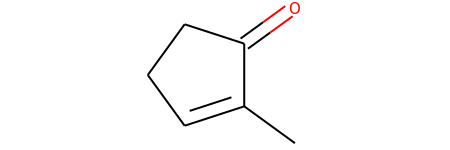

In [ ]:
# visualize molecule using 2D diagram (hydrogen gets lost during smiles conversion)
m = mols['dsgdb9nsd_002129']
m_2d = Chem.MolFromSmiles(Chem.MolToSmiles(m)); m_2d 

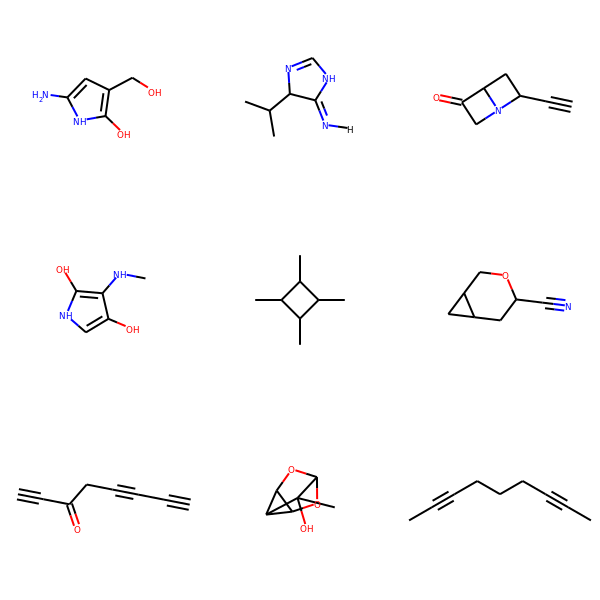

In [ ]:
# 9 random molecules using rdkit grid
names = np.random.choice(list(mols.keys()), 9)
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mols[_])) for _ in names], molsPerRow=3)

## highlight the bond given in train/test

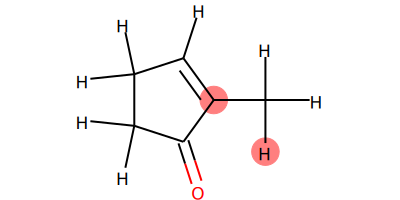

In [ ]:

m = mols['dsgdb9nsd_002129']
atom_index_0 = int(train[train.molecule_name == 'dsgdb9nsd_002129'].iloc[0].atom_index_0)
atom_index_1 = int(train[train.molecule_name == 'dsgdb9nsd_002129'].iloc[0].atom_index_1)
highlight = [atom_index_0, atom_index_1]

from IPython.display import SVG
Chem.rdDepictor.Compute2DCoords(m)
drawer = Draw.rdMolDraw2D.MolDraw2DSVG(400, 200)
drawer.DrawMolecule(m,highlightAtoms=highlight)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

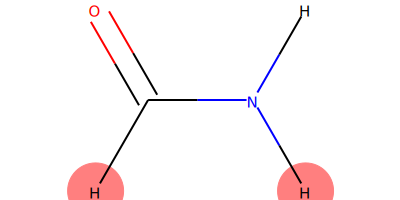

In [ ]:
# 3JHH
row = train[train.type == '3JHH'].iloc[1]
m = mols[row.molecule_name]
atom_index_0 = int(row.atom_index_0)
atom_index_1 = int(row.atom_index_1)
highlight = [atom_index_0, atom_index_1]

from IPython.display import SVG
Chem.rdDepictor.Compute2DCoords(m)
drawer = Draw.rdMolDraw2D.MolDraw2DSVG(400, 200)
drawer.DrawMolecule(m,highlightAtoms=highlight)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

# prepare dataframe

In [ ]:
from pathlib import Path
from sklearn import *
PATH = Path('../input')
# again, only using 5% of data for the committed kernel to work...
# train = pd.read_csv(PATH/'train.csv')[::20]
# test = pd.read_csv(PATH/'test.csv')[::20]

In [ ]:
train['atom1'] = train['type'].map(lambda x: str(x)[2])
train['atom2'] = train['type'].map(lambda x: str(x)[3])
test['atom1'] = test['type'].map(lambda x: str(x)[2])
test['atom2'] = test['type'].map(lambda x: str(x)[3])

In [ ]:
lbl = preprocessing.LabelEncoder()
for i in range(4):
    train['type'+str(i)] = lbl.fit_transform(train['type'].map(lambda x: str(x)[i]))
    test['type'+str(i)] = lbl.transform(test['type'].map(lambda x: str(x)[i]))

In [ ]:
#structures = pd.read_csv(PATH/'structures.csv').rename(columns={'atom_index':'atom_index_0', 'x':'x0', 'y':'y0', 'z':'z0', 'atom':'atom1'})
train = pd.merge(train, structures, how='left', on=['molecule_name', 'atom_index_0', 'atom1'])
test = pd.merge(test, structures, how='left', on=['molecule_name', 'atom_index_0', 'atom1'])
del structures

# extract atom features

In [ ]:
def feature_atom(atom):
    prop = {}
    nb = [a.GetSymbol() for a in atom.GetNeighbors()] # neighbor atom type symbols
    nb_h = sum([_ == 'H' for _ in nb]) # number of hydrogen as neighbor
    nb_o = sum([_ == 'O' for _ in nb]) # number of oxygen as neighbor
    nb_c = sum([_ == 'C' for _ in nb]) # number of carbon as neighbor
    nb_n = sum([_ == 'N' for _ in nb]) # number of nitrogen as neighbor
    nb_na = len(nb) - nb_h - nb_o - nb_n - nb_c
    prop['degree'] = atom.GetDegree()
    prop['hybridization'] = int(atom.GetHybridization())
    prop['inring'] = int(atom.IsInRing()) # is the atom in a ring?
    prop['inring3'] = int(atom.IsInRingSize(3)) # is the atom in a ring size of 3?
    prop['inring4'] = int(atom.IsInRingSize(4)) # is the atom in a ring size of 4?
    prop['inring5'] = int(atom.IsInRingSize(5)) # ...
    prop['inring6'] = int(atom.IsInRingSize(6))
    prop['inring7'] = int(atom.IsInRingSize(7))
    prop['inring8'] = int(atom.IsInRingSize(8))
    prop['nb_h'] = nb_h
    prop['nb_o'] = nb_o
    prop['nb_c'] = nb_c
    prop['nb_n'] = nb_n
    prop['nb_na'] = nb_na
    return prop

In [ ]:
# atom feature of dsgdb9nsd_002129 atom_index_0
molecule_name = 'dsgdb9nsd_002129'
row = train[train.molecule_name == molecule_name].iloc[0]
atom_index_0 = int(row.atom_index_0)
atom_index_1 = int(row.atom_index_1)
m = MolFromXYZ(PATH/f'structures/{molecule_name}.xyz')
a0 = m.GetAtomWithIdx(atom_index_0)
feature_atom(a0)

{'degree': 1,
 'hybridization': 1,
 'inring': 0,
 'inring3': 0,
 'inring4': 0,
 'inring5': 0,
 'inring6': 0,
 'inring7': 0,
 'inring8': 0,
 'nb_h': 0,
 'nb_o': 0,
 'nb_c': 1,
 'nb_n': 0,
 'nb_na': 0}

In [ ]:
a1 = m.GetAtomWithIdx(atom_index_1)
feature_atom(a1)

{'degree': 3,
 'hybridization': 3,
 'inring': 1,
 'inring3': 0,
 'inring4': 0,
 'inring5': 1,
 'inring6': 0,
 'inring7': 0,
 'inring8': 0,
 'nb_h': 1,
 'nb_o': 0,
 'nb_c': 2,
 'nb_n': 0,
 'nb_na': 0}

In [ ]:
# extract some simple atomic feature for atom_index_0 and atom_index_1
# use cached rdkit mol object to save memory
if 'mols' in locals(): del mols
import gc
gc.collect()

# fix atom bonds
# dsgdb9nsd_059827: hydrogen has is far apart
nblist = {
    'dsgdb9nsd_059827': {
        13: 3
    }
}

def _features(args):
    idx, row = args
    molecule_name = row.molecule_name
    atom_index_0 = int(row.atom_index_0)
    atom_index_1 = int(row.atom_index_1)
    
    prop = {'molecule_name': molecule_name,
            'atom_index_0': atom_index_0,
            'atom_index_1': atom_index_1}

    # atom_0 is always hydrogen
    m = MolFromXYZ(PATH/f'structures/{molecule_name}.xyz') # less memory intensive in multiprocessing.Pool
    a0 = m.GetAtomWithIdx(atom_index_0)

    a1 = m.GetAtomWithIdx(atom_index_1)
    a1_prop = feature_atom(a1)
    prop.update({'a1_'+k: a1_prop[k] for k in a1_prop.keys()})

    # skipping below for time constraint
    # neighbor of atom_0
    try:
        a0_nb_idx = [a.GetIdx() for a in a0.GetNeighbors() if a.GetIdx() != a0].pop()
    except:
        if molecule_name in nblist and atom_index_0 in nblist[molecule_name]:
            a0_nb_idx = nblist[molecule_name][atom_index_0]
        else:
            print(molecule_name)
            print(row)

    a0_nb = m.GetAtomWithIdx(a0_nb_idx)
    a0_nb_prop = feature_atom(a0_nb)
    for k in a0_nb_prop.keys():
        prop['a0_nb_'+k] = a0_nb_prop[k]
        
    c = m.GetConformer()
    #prop['dist_a0_a0_nb'] = np.linalg.norm(c.GetAtomPosition(atom_index_0) - c.GetAtomPosition(a0_nb_idx))
    prop['x_a0_nb'] = c.GetAtomPosition(a0_nb_idx)[0]
    prop['y_a0_nb'] = c.GetAtomPosition(a0_nb_idx)[1]
    prop['z_a0_nb'] = c.GetAtomPosition(a0_nb_idx)[2]

    # neighbor of atom_1
    try:
        a1_nb_idx = [a.GetIdx() for a in a1.GetNeighbors() if a.GetIdx() != a1].pop()
    except:
        if molecule_name in nblist and atom_index_1 in nblist[molecule_name]:
            a1_nb_idx = nblist[molecule_name][atom_index_1]
        else:
            print(molecule_name)
            print(row)
    a1_nb = m.GetAtomWithIdx(a1_nb_idx)
    a1_nb_prop = feature_atom(a1_nb)
    for k in a1_nb_prop.keys():
        prop['a1_nb_'+k] = a1_nb_prop[k]
    prop['x_a1_nb'] = c.GetAtomPosition(a1_nb_idx)[0]
    prop['y_a1_nb'] = c.GetAtomPosition(a1_nb_idx)[1]
    prop['z_a1_nb'] = c.GetAtomPosition(a1_nb_idx)[2]
    #prop['dist_a1_a1_nb'] = np.linalg.norm(c.GetAtomPosition(a1.GetIdx()) - c.GetAtomPosition(a1_nb.GetIdx()))
    #prop['dist_a0_a1_nb'] = np.linalg.norm(c.GetAtomPosition(a0.GetIdx()) - c.GetAtomPosition(a1_nb.GetIdx()))
    #prop['dist_a1_a0_nb'] = np.linalg.norm(c.GetAtomPosition(a1.GetIdx()) - c.GetAtomPosition(a0_nb.GetIdx()))
    return prop

def features(df):
    prop = []
    n_cpu = 4
    with Pool(n_cpu) as p:
        n = len(df)
        res = _features((0, df.iloc[0]))
        keys = res.keys()
        _df = df[['molecule_name', 'atom_index_0', 'atom_index_1']]
        with tqdm(total=n) as pbar:
            for res in p.imap_unordered(_features, _df.iterrows()):
                # this is faster than using dict
                prop.append([res[_] for _ in keys])
                pbar.update()
        del _df
    
    prop = pd.DataFrame.from_records(prop, columns=keys)
    df = pd.merge(df, prop, how='left', on=['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df

train = features(train)
test = features(test)

100%|██████████| 125278/125278 [02:53<00:00, 722.43it/s]


In [ ]:
train.drop(columns=['id', 'molecule_name', 'atom1', 'atom2', 'atom_index_0', 'atom_index_1'], inplace=True)
test.drop(columns=['molecule_name', 'atom1', 'atom2', 'atom_index_0', 'atom_index_1'], inplace=True)

In [ ]:

train_p0 = train[['x0', 'y0', 'z0']].values
train_p1 = train[['x1', 'y1', 'z1']].values
test_p0 = test[['x0', 'y0', 'z0']].values
test_p1 = test[['x1', 'y1', 'z1']].values

train['dist'] = np.linalg.norm(train_p0 - train_p1, axis=1)
test['dist'] = np.linalg.norm(test_p0 - test_p1, axis=1)

train['dist_to_type_mean'] = train['dist'] / train.groupby('type')['dist'].transform('mean')
test['dist_to_type_mean'] = test['dist'] / test.groupby('type')['dist'].transform('mean')
del train_p0, train_p1
del test_p0, test_p1

In [ ]:
col = [c for c in train.columns if c not in ['scalar_coupling_constant']]
reg = ensemble.ExtraTreesRegressor(n_jobs=-1, n_estimators=20, random_state=4, verbose=1)

In [ ]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train[col], train['scalar_coupling_constant'], test_size=0.2)

In [ ]:
reg.fit(X_train.drop(['type'], axis=1), y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   18.4s finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
          oob_score=False, random_state=4, verbose=1, warm_start=False)

In [ ]:

def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [ ]:
y_pred = reg.predict(X_valid.drop('type', axis=1))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.2s finished


In [ ]:
group_mean_log_mae(y_valid, y_pred, X_valid.type)

-0.14910813316658145

Model

In [ ]:
Y_train = input_train["label"]
X_train = input_train.drop(labels = ["label"],axis = 1) 
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
input_train.groupby("label",axis=0).size()

del input_train 

In [ ]:
X_train = X_train / 255
X_train  = X_train.round()
input_test = input_test / 255
input_test  = input_test.round()

In [ ]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [ ]:
from sklearn.model_selection import train_test_split
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input,concatenate,DepthwiseConv2D,Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

In [ ]:
def evaluate_model(model,X_train,Y_train,X_val,Y_val,saveModelName,epochs,batch_size):
    filepath=saveModelName+".hdf5"
    best_accuracy_model = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,best_accuracy_model]) 
    model.load_weights(filepath)
    return model,history

In [ ]:
def plot_results(history):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    
# Saving results
result_table_columns = ['CNN Model','Train Accuracy','Test Accuracy']
results = pd.DataFrame(columns=result_table_columns)

def add_result(name,history,results,row):
    results.loc[row,'CNN Model'] = name
    results.loc[row,'Train Accuracy'] = history.history['accuracy'][np.argmax(history.history['val_accuracy'])]
    results.loc[row,'Test Accuracy'] = max(history.history['val_accuracy'])
    return results

In [ ]:
def singelHiddenLayer(pixelcount):
    model = Sequential()
    model.add(Dense(pixelcount, input_dim=pixelcount, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

flat_X_train = X_train.reshape((X_train.shape[0],-1))
model = singelHiddenLayer(flat_X_train.shape[1])
model.fit(flat_X_train, Y_train,epochs=50, batch_size=200, verbose=2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
189/189 - 2s - loss: 0.3541 - accuracy: 0.8976 - 2s/epoch - 12ms/step
Epoch 2/50
189/189 - 2s - loss: 0.1452 - accuracy: 0.9588 - 2s/epoch - 9ms/step
Epoch 3/50
189/189 - 2s - loss: 0.0919 - accuracy: 0.9747 - 2s/epoch - 9ms/step
Epoch 4/50
189/189 - 2s - loss: 0.0613 - accuracy: 0.9839 - 2s/epoch - 9ms/step
Epoch 5/50
189/189 - 2s - loss: 0.0423 - accuracy: 0.9896 - 2s/epoch - 9ms/step
Epoch 6/50
189/189 - 2s - loss: 0.0273 -

In [ ]:
def model_2CMDr_2CMDr_FDDr_D():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'same', activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    print(model.summary())
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                      

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-19-0b82546dbb66>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),



Epoch 1: val_accuracy improved from -inf to 0.96857, saving model to model_2CMDr_2CMDr_FDDr_D.best.hdf5
590/590 - 175s - loss: 0.3821 - accuracy: 0.8789 - val_loss: 0.1104 - val_accuracy: 0.9686 - lr: 0.0010 - 175s/epoch - 296ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.96857 to 0.98357, saving model to model_2CMDr_2CMDr_FDDr_D.best.hdf5
590/590 - 169s - loss: 0.1280 - accuracy: 0.9618 - val_loss: 0.0555 - val_accuracy: 0.9836 - lr: 0.0010 - 169s/epoch - 287ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.98357 to 0.98786, saving model to model_2CMDr_2CMDr_FDDr_D.best.hdf5
590/590 - 168s - loss: 0.1010 - accuracy: 0.9702 - val_loss: 0.0418 - val_accuracy: 0.9879 - lr: 0.0010 - 168s/epoch - 285ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98786 to 0.98952, saving model to model_2CMDr_2CMDr_FDDr_D.best.hdf5
590/590 - 170s - loss: 0.0891 - accuracy: 0.9743 - val_loss: 0.0339 - val_accuracy: 0.9895 - lr: 0.0010 - 170s/epoch - 289ms/step
Epoch 5/10

Epoch 

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.979224,0.990238


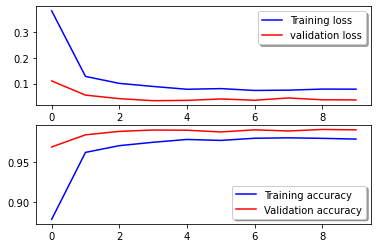

In [ ]:
epochs = 10
model = model_2CMDr_2CMDr_FDDr_D()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_2CMDr_2CMDr_FDDr_D.best",epochs,64)
plot_results(history)

results = add_result("2CMDr_2CMDr_FDDr_D",history,results,0)
results

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                             

<ipython-input-19-0b82546dbb66>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),



Epoch 1: val_accuracy improved from -inf to 0.97119, saving model to model_vgg_64_4.best.hdf5
590/590 - 354s - loss: 0.3274 - accuracy: 0.8974 - val_loss: 0.1114 - val_accuracy: 0.9712 - lr: 0.0010 - 354s/epoch - 599ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.97119 to 0.97643, saving model to model_vgg_64_4.best.hdf5
590/590 - 341s - loss: 0.1197 - accuracy: 0.9643 - val_loss: 0.0831 - val_accuracy: 0.9764 - lr: 0.0010 - 341s/epoch - 579ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.97643 to 0.97810, saving model to model_vgg_64_4.best.hdf5
590/590 - 338s - loss: 0.0931 - accuracy: 0.9712 - val_loss: 0.0800 - val_accuracy: 0.9781 - lr: 0.0010 - 338s/epoch - 572ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.97810 to 0.98190, saving model to model_vgg_64_4.best.hdf5
590/590 - 339s - loss: 0.0768 - accuracy: 0.9770 - val_loss: 0.0583 - val_accuracy: 0.9819 - lr: 0.0010 - 339s/epoch - 575ms/step
Epoch 5/10

Epoch 5: val_accuracy improved from 0.98190 to

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.979224,0.990238
1,vgg_64_4,0.985611,0.990952


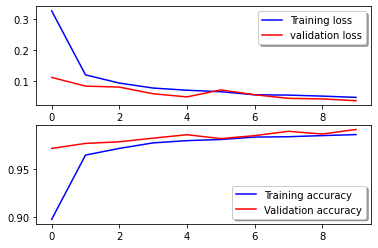

In [ ]:
def vgg_model(n_filters,n_conv):
    visible = Input(shape=(28, 28, 1))
    layers= visible
    for _ in range(n_conv):
        layers = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layers)
    #add max pooling layer
    layers = MaxPooling2D((2,2), strides=(2,2))(layers)
    layers = Flatten()(layers)
    output = Dense(10,activation='softmax')(layers)
    model = Model(inputs=visible, outputs=output)
    print(model.summary())
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = vgg_model(64,4)
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_vgg_64_4.best",epochs,64)
plot_results(history)
results = add_result("vgg_64_4",history,results,1)
results

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_2 (Batc  (None, 24, 24, 32)      

<ipython-input-19-0b82546dbb66>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),



Epoch 1: val_accuracy improved from -inf to 0.96714, saving model to model_vgg_batchNormalize.best.hdf5
590/590 - 242s - loss: 0.6358 - accuracy: 0.8029 - val_loss: 0.1132 - val_accuracy: 0.9671 - lr: 0.0010 - 242s/epoch - 411ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.96714 to 0.98048, saving model to model_vgg_batchNormalize.best.hdf5
590/590 - 239s - loss: 0.1681 - accuracy: 0.9505 - val_loss: 0.0664 - val_accuracy: 0.9805 - lr: 0.0010 - 239s/epoch - 405ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.98048 to 0.98548, saving model to model_vgg_batchNormalize.best.hdf5
590/590 - 240s - loss: 0.1298 - accuracy: 0.9616 - val_loss: 0.0491 - val_accuracy: 0.9855 - lr: 0.0010 - 240s/epoch - 406ms/step
Epoch 4/10

Epoch 4: val_accuracy did not improve from 0.98548
590/590 - 240s - loss: 0.1079 - accuracy: 0.9679 - val_loss: 0.0581 - val_accuracy: 0.9826 - lr: 0.0010 - 240s/epoch - 406ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.98548
590/590 - 2

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.979224,0.990238
1,vgg_64_4,0.985611,0.990952
2,vgg_batchNormalize,0.983994,0.99119


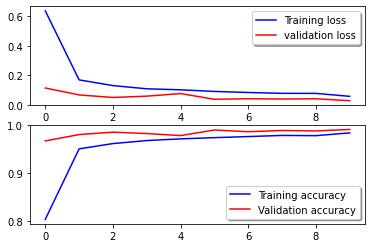

In [ ]:
def model_vgg_batchNormalize():
    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    print(model.summary())
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = model_vgg_batchNormalize()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_vgg_batchNormalize.best",epochs,64)
plot_results(history)
results = add_result("vgg_batchNormalize",history,results,2)
results

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 28, 28, 16)   32          ['input_2[0][0]']                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 28, 28, 16)   32          ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 28, 28, 1)   0           ['input_2[0][0]']                
                                                                                            

<ipython-input-19-0b82546dbb66>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),



Epoch 1: val_accuracy improved from -inf to 0.97810, saving model to model_Inception.best.hdf5
590/590 - 403s - loss: 0.3308 - accuracy: 0.8961 - val_loss: 0.0758 - val_accuracy: 0.9781 - lr: 0.0010 - 403s/epoch - 683ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.97810 to 0.98143, saving model to model_Inception.best.hdf5
590/590 - 408s - loss: 0.1350 - accuracy: 0.9581 - val_loss: 0.0619 - val_accuracy: 0.9814 - lr: 0.0010 - 408s/epoch - 692ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.98143 to 0.98262, saving model to model_Inception.best.hdf5
590/590 - 407s - loss: 0.1064 - accuracy: 0.9683 - val_loss: 0.0623 - val_accuracy: 0.9826 - lr: 0.0010 - 407s/epoch - 689ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.98262 to 0.98476, saving model to model_Inception.best.hdf5
590/590 - 406s - loss: 0.0922 - accuracy: 0.9730 - val_loss: 0.0597 - val_accuracy: 0.9848 - lr: 0.0010 - 406s/epoch - 688ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.979224,0.990238
1,vgg_64_4,0.985611,0.990952
2,vgg_batchNormalize,0.983994,0.99119
3,Inception,0.979688,0.987857


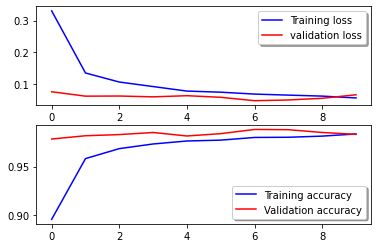

In [ ]:
def model_Inception():
    input_img = Input(shape=(28, 28, 1))
    # Layer 1
    layer1_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer1_tower_1)
    
    layer1_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer1_tower_2)

    layer1_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
    layer1_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_tower_3)

    layer1_output = concatenate([layer1_tower_1, layer1_tower_2, layer1_tower_3, layer1_tower_0], axis=1)

    # Layer 2
    layer2_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer2_tower_1)

    layer2_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer2_tower_2)

    layer2_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer1_output)
    layer2_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer2_tower_3)

    layer2_output = concatenate([layer2_tower_1, layer2_tower_2, layer2_tower_3, layer2_tower_0], axis=1)

    # Flatten & Dense
    layer2_output = Flatten()(layer2_output)
    output = Dense(10,activation='softmax')(layer2_output)
    
    inception_Model = Model(inputs=input_img,outputs=output)
    
    print(inception_Model.summary())
    inception_Model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return inception_Model

model = model_Inception()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_Inception.best",epochs,64)
plot_results(history)
results = add_result("Inception",history,results,3)
results

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_29 (Conv2D)             (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 14, 14, 32)  128         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_7 (Dropout)            (None, 14, 14, 32)   0           ['batch_normalization_11[0]

<ipython-input-19-0b82546dbb66>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),



Epoch 1: val_accuracy improved from -inf to 0.84119, saving model to model_Xception.best.hdf5
590/590 - 1113s - loss: 0.9685 - accuracy: 0.7832 - val_loss: 0.7918 - val_accuracy: 0.8412 - lr: 0.0010 - 1113s/epoch - 2s/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.84119 to 0.93024, saving model to model_Xception.best.hdf5
590/590 - 1103s - loss: 0.4117 - accuracy: 0.9206 - val_loss: 0.4701 - val_accuracy: 0.9302 - lr: 0.0010 - 1103s/epoch - 2s/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.93024 to 0.96667, saving model to model_Xception.best.hdf5
590/590 - 1098s - loss: 0.2858 - accuracy: 0.9443 - val_loss: 0.1718 - val_accuracy: 0.9667 - lr: 0.0010 - 1098s/epoch - 2s/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.96667 to 0.97357, saving model to model_Xception.best.hdf5
590/590 - 1090s - loss: 0.2301 - accuracy: 0.9519 - val_loss: 0.1193 - val_accuracy: 0.9736 - lr: 0.0010 - 1090s/epoch - 2s/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.97357

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.979224,0.990238
1,vgg_64_4,0.985611,0.990952
2,vgg_batchNormalize,0.983994,0.99119
3,Inception,0.979688,0.987857
4,Xception,0.971645,0.987857


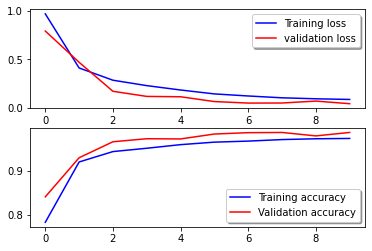

In [ ]:
def model_Xception():
    inp = Input(shape = (28, 28, 1))
    x = inp
    x = Conv2D(32, (3, 3), strides = 2, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)

    x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = MaxPooling2D((2, 2), strides = 1)(x1)

    x = concatenate([x1, Conv2D(64, (2, 2), strides = 1)(x)])

    x1 = Activation("relu")(x)
    x1 = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = MaxPooling2D((2, 2), strides = 1)(x1)

    x = concatenate([x1, Conv2D(256, (2, 2), strides = 1)(x)])

    x = Activation("relu")(x)
    x = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)

    x = Dense(10, activation = "softmax")(x)

    xception = Model(inp, x)
    print(xception.summary())
    xception.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return xception

model = model_Xception()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_Xception.best",epochs,64)
plot_results(history)
results = add_result("Xception",history,results,4)
results

In [ ]:
results

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.979224,0.990238
1,vgg_64_4,0.985611,0.990952
2,vgg_batchNormalize,0.983994,0.99119
3,Inception,0.979688,0.987857
4,Xception,0.971645,0.987857


In [ ]:
## predict results
# model = model_2CMDr_2CMDr_FDDr_D()  #99.214%
# model = vgg_model(64,4) #99.476%
model = model_vgg_batchNormalize()  #99.73%
# model = model_Inception()  #99.21%
# model = model_Xception()  #99.57%

model.load_weights("model_vgg_batchNormalize.best.hdf5")

test_data = input_test.values.reshape(-1,28,28,1)
outputs = model.predict(test_data)

# select the index with the maximum probability
outputs = np.argmax(outputs,axis = 1)

outputs = pd.Series(outputs,name="Label")
outputs

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_20 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_37 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_21 (Bat  (None, 24, 24, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_38 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_22 (Bat  (None, 24, 24, 32)      

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64